In [ ]:
!pip install beautifultable
!pip install bootstrapped

  Preparing metadata (setup.py) ... done
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13932 sha256=f206f90a9297368edfa77904fd62ce1547f17a70e20c00ca1aeb8afb099baab9
  Stored in directory: /root/.cache/pip/wheels/8b/47/d1/909397af2748ea916f6b72c346055e2426e7980bd1894b3633
Successfully built bootstrapped


In [ ]:
from beautifultable import BeautifulTable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from sklearn import preprocessing

In [ ]:
# Path to the root AReM folder (uploaded or mounted in Colab)
base_path = '/content/drive/MyDrive/AReM'

columnNames = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

X_train, y_train, X_test, y_test = [], [], [], []

def readData(filePath):
    data = []
    with open(filePath, 'r') as f:
        lines = f.readlines()

    for line in lines[5:]:  # Skip 5 header lines
        line = line.strip()

        # Try comma first, fallback to whitespace
        if ',' in line:
            tokens = line.split(',')
        else:
            tokens = line.split()

        try:
            # Skip time column, parse float values
            row = [float(x.strip()) for x in tokens[1:] if x.strip() != '']
            if len(row) == 6:
                data.append(row)
        except ValueError:
            continue

    if len(data) < 479:
        return None  # Too few valid rows

    # Pad or truncate to 480 rows
    while len(data) < 480:
        data.append(data[-1])  # Pad by duplicating last row
    if len(data) > 480:
        data = data[:480]

    return pd.DataFrame(data, columns=columnNames)

# Load data per activity and dataset
for activity in sorted(os.listdir(base_path)):
    activity_path = os.path.join(base_path, activity)
    if not os.path.isdir(activity_path):
        continue

    print(f"\n--- Processing activity: {activity} ---")
    for file in sorted(os.listdir(activity_path)):
        if not file.endswith('.csv'):
            continue

        file_path = os.path.join(activity_path, file)
        filename_no_ext = os.path.splitext(file)[0]

        df = readData(file_path)

        if df is None:
            print(f"Skipping {file} due to too few valid rows")
            continue

        data_array = df.values

        # Train/test split
        if activity.lower() in ['bending1', 'bending2']:
            if filename_no_ext in ['dataset1', 'dataset2']:
                X_test.append(data_array)
                y_test.append(activity)
            else:
                X_train.append(data_array)
                y_train.append(activity)
        else:
            if filename_no_ext in ['dataset1', 'dataset2', 'dataset3']:
                X_test.append(data_array)
                y_test.append(activity)
            else:
                X_train.append(data_array)
                y_train.append(activity)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


--- Processing activity: .ipynb_checkpoints ---

--- Processing activity: bending1 ---

--- Processing activity: bending2 ---

--- Processing activity: cycling ---

--- Processing activity: lying ---

--- Processing activity: sitting ---

--- Processing activity: standing ---

--- Processing activity: walking ---


In [ ]:
print(f"Train set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

Train set: (69, 480, 6), Labels: (69,)
Test set: (19, 480, 6), Labels: (19,)


In [ ]:
# Define standard column names
stat_names = ['min', 'max', 'mean', 'median', 'std', 'q1', 'q3']
columnNames = [f"{stat}_{i+1}" for i in range(6) for stat in stat_names]

def extract_features(X):
    features = []
    for instance in X:
        instance_features = []
        for col in range(instance.shape[1]):  # 6 time series
            ts = instance[:, col]
            instance_features.extend([
                np.min(ts),
                np.max(ts),
                np.mean(ts),
                np.median(ts),
                np.std(ts),
                np.percentile(ts, 25),  # 1st quartile
                np.percentile(ts, 75),  # 3rd quartile
            ])
        features.append(instance_features)
    return pd.DataFrame(features)

# Extract features for train and test sets
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

# Set consistent column names
X_train_features.columns = columnNames
X_test_features.columns = columnNames

# Attach labels
X_train_features['label'] = y_train
X_test_features['label'] = y_test

print("✅ Feature extraction complete!")
print(f"X_train_features shape: {X_train_features.shape}")
print(f"X_test_features shape: {X_test_features.shape}")


✅ Feature extraction complete!
X_train_features shape: (69, 43)
X_test_features shape: (19, 43)


In [ ]:
X_train_features.head()

,min_1,max_1,mean_1,median_1,std_1,q1_1,q3_1,min_2,max_2,mean_2,...,q1_5,q3_5,min_6,max_6,mean_6,median_6,std_6,q1_6,q3_6,label
0,35.00,47.40,43.954500,44.33,1.557210,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.43,0.512971,0.00,0.94,bending1
1,33.00,47.75,42.179812,43.50,3.666840,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.50,0.523771,0.00,1.00,bending1
2,33.00,45.75,41.678063,41.75,2.241152,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.43,0.388759,0.00,0.50,bending1
3,37.00,48.00,43.454958,43.25,1.384653,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.50,0.621885,0.43,0.87,bending1
4,36.25,48.00,43.969125,44.50,1.616677,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487318,0.00,0.83,bending1


In [ ]:
# Print data in a tabular form
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(maxwidth=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [ ]:
# Calculate standard deviations from training features
X_all_features = pd.concat([X_train_features, X_test_features], ignore_index=True)
X_all_features.columns = columnNames + ['label']
X_numeric = X_all_features.select_dtypes(include=[np.number])

# Compute std dev for each feature
stds = X_numeric.std()
columns = X_numeric.columns

# Build table
tableHeaders = ['Feature Name', 'Standard Deviation']
tableData = [[col, stds[col]] for col in columns]

print('STANDARD DEVIATION OF TIME-DOMAIN FEATURES:')
printDatainTable(tableHeaders, tableData)

STANDARD DEVIATION OF TIME-DOMAIN FEATURES:
+==============+====================+
| Feature Name | Standard Deviation |
+==============+====================+
|    min_1     |        9.57        |
+--------------+--------------------+
|    max_1     |       4.394        |
+--------------+--------------------+
|    mean_1    |       5.336        |
+--------------+--------------------+
|   median_1   |        5.44        |
+--------------+--------------------+
|    std_1     |        1.77        |
+--------------+--------------------+
|     q1_1     |       6.154        |
+--------------+--------------------+
|     q3_1     |       5.139        |
+--------------+--------------------+
|    min_2     |        0.0         |
+--------------+--------------------+
|    max_2     |       5.063        |
+--------------+--------------------+
|    mean_2    |       1.574        |
+--------------+--------------------+
|   median_2   |       1.412        |
+--------------+--------------------+
|    s

/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


In [ ]:
tableData = []
for i in range(0, len(X_numeric.columns)):
    row = []
    col_name = X_numeric.columns[i]
    samples = X_numeric.iloc[:, i].values
    bootResult = bs.bootstrap(samples, stat_func=bs_stats.std, alpha=0.1)
    row.append(col_name)
    row.append(stds[col_name])
    row.append(bootResult.lower_bound)
    row.append(bootResult.upper_bound)
    tableData.append(row)

print('STANDARD DEVIATION & 90% BOOTSTRAP CONFIDENCE INTERVAL OF TIME-DOMAIN FEATURES:')
tableHeader = ['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound']
printDatainTable(tableHeader, tableData)

STANDARD DEVIATION & 90% BOOTSTRAP CONFIDENCE INTERVAL OF TIME-DOMAIN FEATURES:
+==============+====================+=============+=============+
| Feature Name | Standard Deviation | Lower Bound | Upper Bound |
+==============+====================+=============+=============+
|    min_1     |        9.57        |    8.344    |   10.792    |
+--------------+--------------------+-------------+-------------+
|    max_1     |       4.394        |    3.473    |    5.42     |
+--------------+--------------------+-------------+-------------+
|    mean_1    |       5.336        |    4.768    |    5.928    |
+--------------+--------------------+-------------+-------------+
|   median_1   |        5.44        |    4.853    |    6.056    |
+--------------+--------------------+-------------+-------------+
|    std_1     |        1.77        |    1.582    |    1.959    |
+--------------+--------------------+-------------+-------------+
|     q1_1     |       6.154        |    5.619    |    6.69   

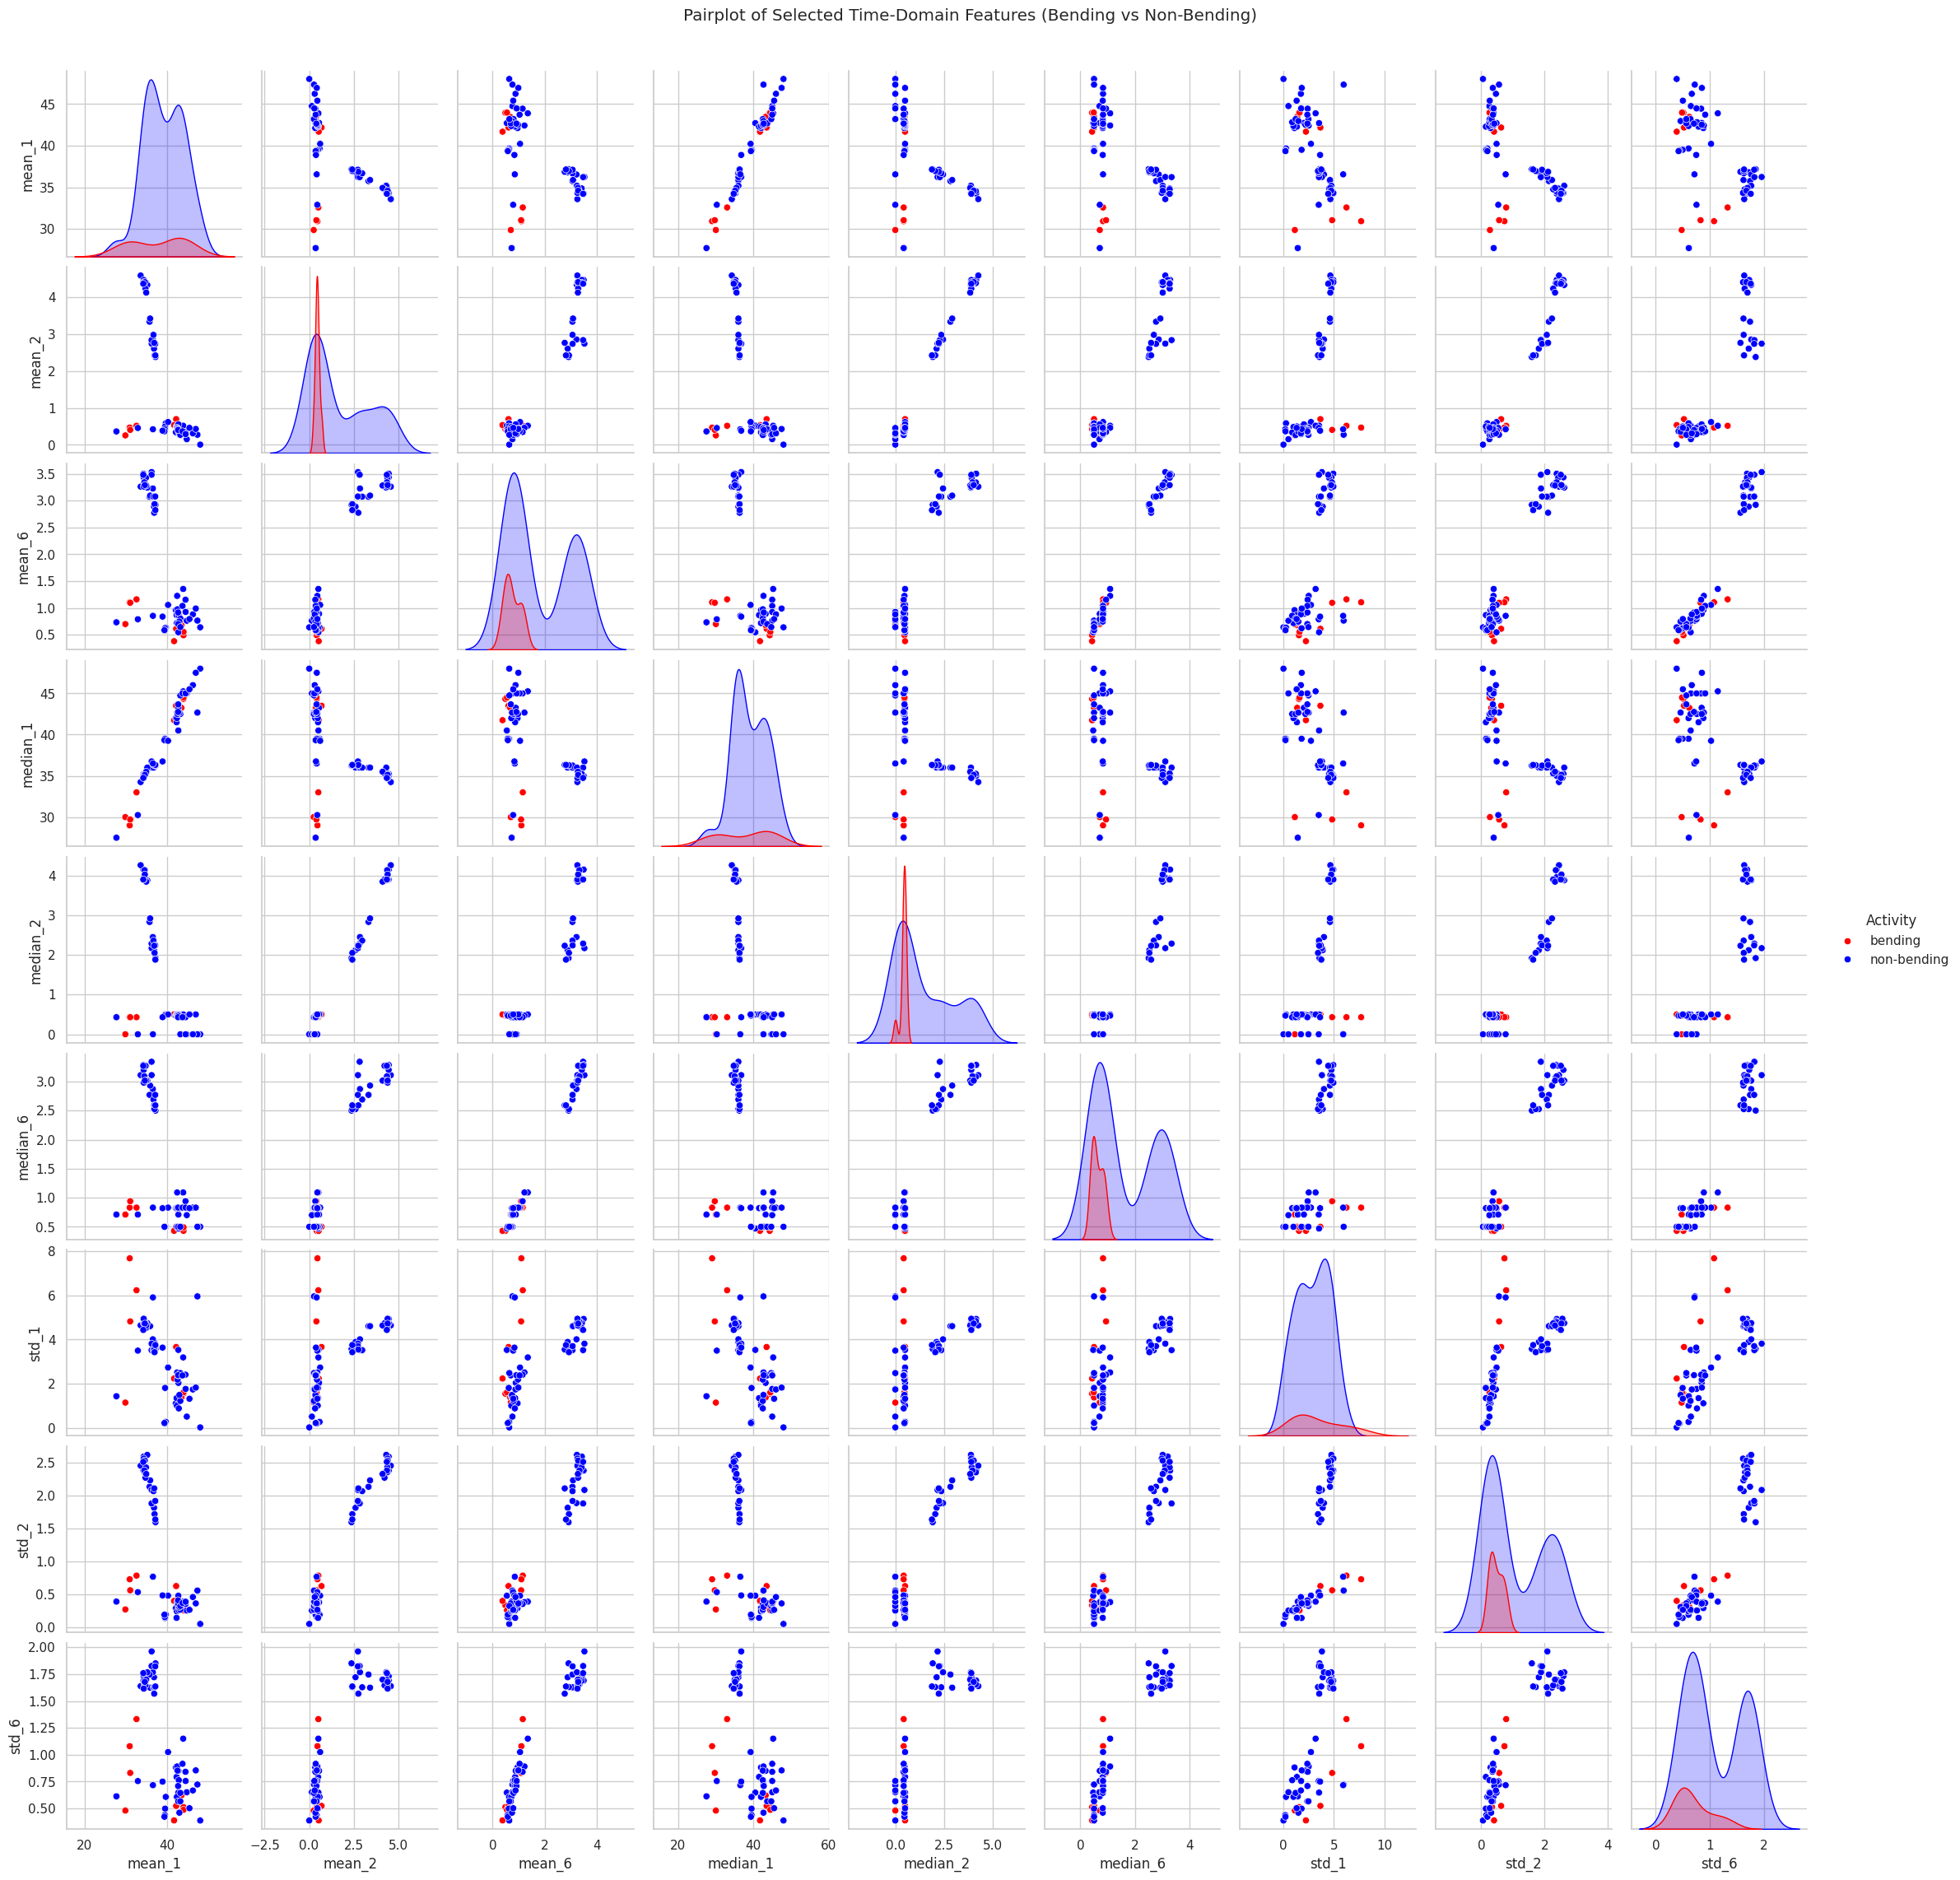

In [ ]:
# Step 1: Select relevant statistics and signals
selectedFeatures = ['mean', 'median', 'std']
featuresToTake = [1, 2, 6]  # time series indices
featuresToPlot = []
plotData = []

# Step 2: Build the data row by row
for i in range(X_train_features.shape[0]):
    row = []
    for feature in selectedFeatures:
        for j in featuresToTake:
            col_name = f"{feature}_{j}"
            row.append(X_train_features.iloc[i][col_name])
            if i == 0:  # only on first pass, build feature names
                featuresToPlot.append(col_name)

    # Add activity label
    activity = y_train[i]
    label = 'bending' if 'bending' in activity.lower() else 'non-bending'
    row.append(label)
    plotData.append(row)

# Step 3: Build DataFrame
featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(plotData, columns=featuresToPlot)

# Step 4: Plot pairplot
sns.set(style='whitegrid')
sns.pairplot(data=trainDataDF, hue='Activity', palette={'bending': 'red', 'non-bending': 'blue'})
plt.suptitle("Pairplot of Selected Time-Domain Features (Bending vs Non-Bending)", y=1.02)
plt.show()

In [ ]:
# Split each instance into two halves and extract time-domain features
def extract_features_from_split(X):
    features = []
    for instance in X:
        instance_features = []
        halves = np.array_split(instance, 2)  # Each half: (240, 6)
        for half in halves:
            for col in range(half.shape[1]):
                ts = half[:, col]
                instance_features.extend([
                    np.min(ts),
                    np.max(ts),
                    np.mean(ts),
                    np.median(ts),
                    np.std(ts),
                    np.percentile(ts, 25),
                    np.percentile(ts, 75)
                ])
        features.append(instance_features)
    return pd.DataFrame(features)

# Extract features from split time series
X_train_features_split = extract_features_from_split(X_train)

# Set column names
stat_names = ['min', 'max', 'mean', 'median', 'std', 'q1', 'q3']
column_names_split = [f"{stat}_{i+1}" for i in range(12) for stat in stat_names]
X_train_features_split.columns = column_names_split

In [ ]:
X_train_features_split.head()

,min_1,max_1,mean_1,median_1,std_1,q1_1,q3_1,min_2,max_2,mean_2,...,std_11,q1_11,q3_11,min_12,max_12,mean_12,median_12,std_12,q1_12,q3_12
0,36.50,46.50,44.057167,44.50,1.553724,43.2500,45.00,0.0,1.50,0.381042,...,2.293899,33.00,36.2500,0.0,1.50,0.388333,0.00,0.477530,0.0000,0.71
1,33.75,47.75,43.278875,45.00,3.466111,42.0000,45.25,0.0,3.00,0.673292,...,3.752276,28.75,33.7500,0.0,2.18,0.586083,0.47,0.490847,0.0000,0.87
2,33.00,45.75,41.621208,42.33,3.112140,39.6525,44.25,0.0,2.83,0.623083,...,2.058345,28.31,30.5625,0.0,1.50,0.347500,0.43,0.362386,0.0000,0.50
3,39.00,48.00,44.117042,45.00,1.357000,43.5000,45.00,0.0,1.30,0.250042,...,1.877797,22.50,23.7500,0.0,4.06,0.543875,0.50,0.472458,0.4300,0.71
4,36.67,45.00,43.486208,43.71,1.279302,42.3300,44.50,0.0,1.30,0.378667,...,1.925470,21.00,23.5000,0.0,2.96,0.585750,0.50,0.486900,0.4225,0.83


In [ ]:
X_train_features_split.shape

(69, 84)

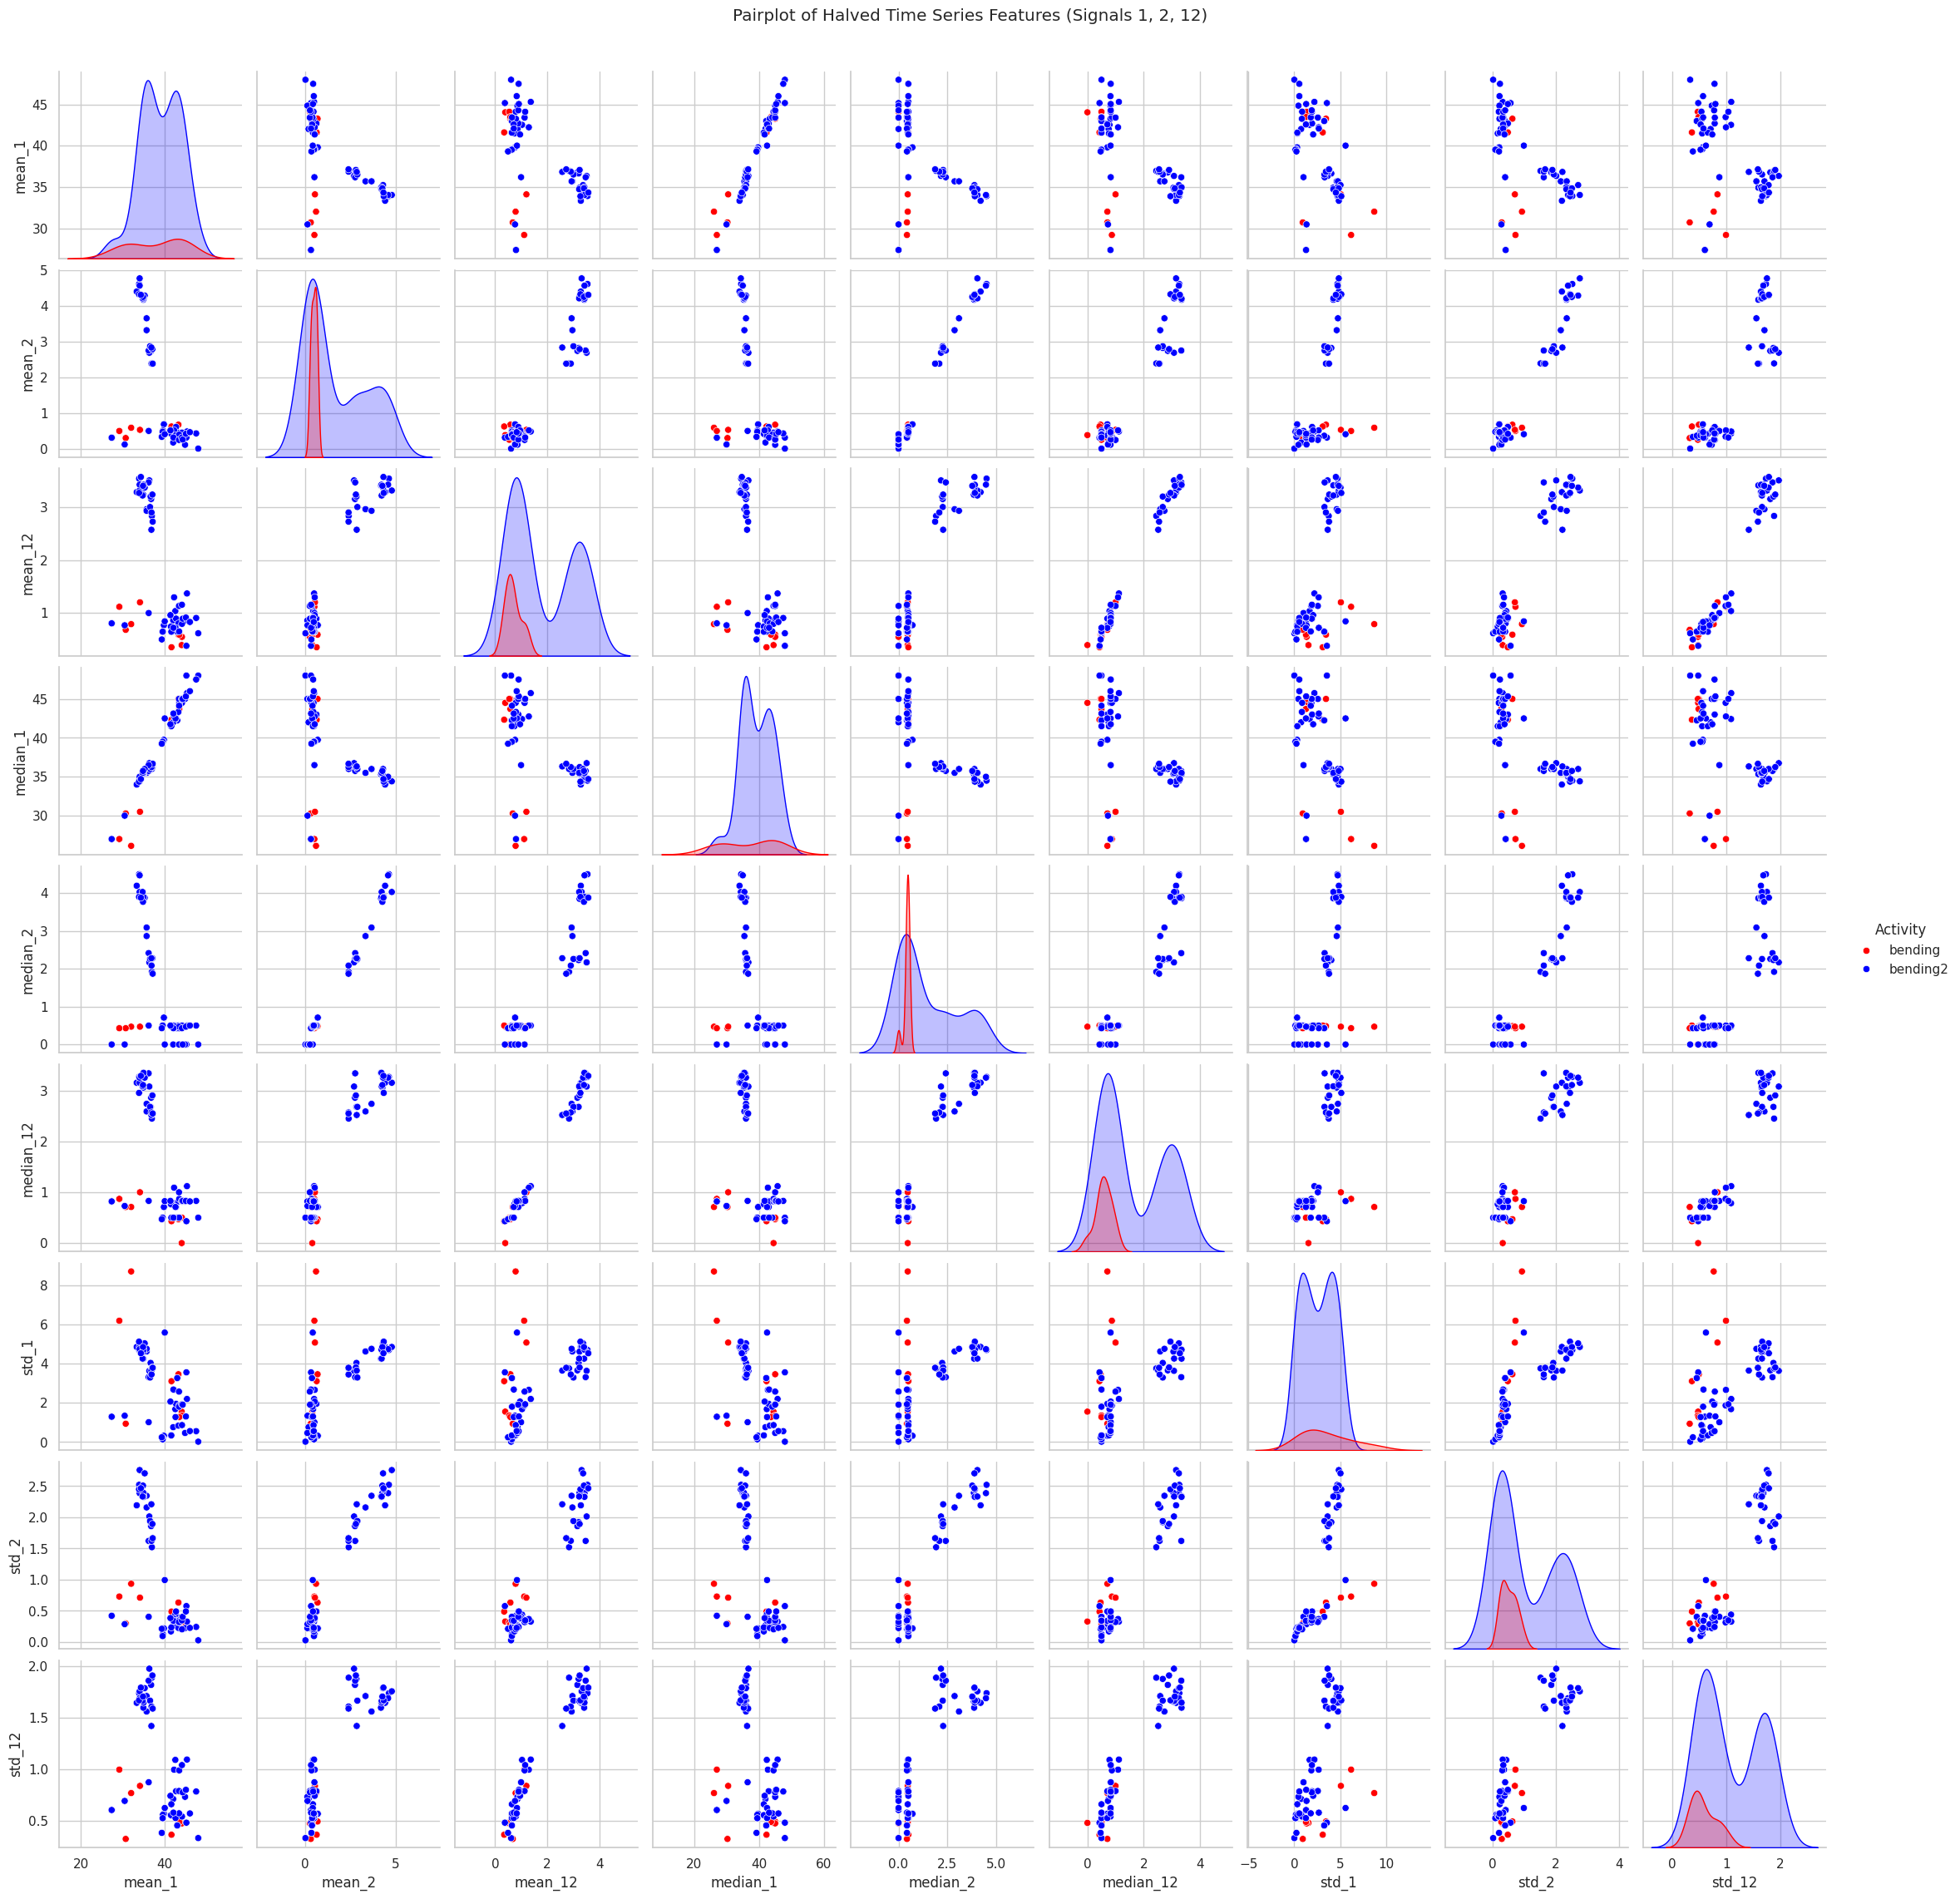

In [ ]:
selectedFeatures = ['mean', 'median', 'std']
featuresToTake = [1, 2, 12]  # signals after halving (1-based)
featuresToPlot = []
plotData = []

for i in range(X_train_features_split.shape[0]):
    row = []
    for feature in selectedFeatures:
        for j in featuresToTake:
            col_name = f"{feature}_{j}"  # e.g., mean_1, mean_12
            row.append(X_train_features_split.iloc[i][col_name])
            if i == 0:
                featuresToPlot.append(col_name)

    activity = y_train[i]
    label = 'bending' if 'bending' in activity.lower() else 'bending2'
    row.append(label)
    plotData.append(row)

# Build DataFrame
featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(plotData, columns=featuresToPlot)

# Plot pairplot
sns.set(style='whitegrid')
sns.pairplot(data=trainDataDF, hue='Activity', palette={'bending': 'red', 'bending2': 'blue'})
plt.suptitle("Pairplot of Halved Time Series Features (Signals 1, 2, 12)", y=1.02)
plt.show()

In [ ]:
def getStatistics(data):
    columnNames = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    df = pd.DataFrame(data, columns=columnNames)
    statistics = df.describe()
    stats = {}
    stats['Mean'] = statistics[1:2].values[0].tolist()
    stats['Std'] = statistics[2:3].values[0].tolist()
    stats['Median'] = statistics[5:6].values[0].tolist()
    stats['Min'] = statistics[3:4].values[0].tolist()
    stats['Max'] = statistics[7:8].values[0].tolist()
    stats['FirstQuartile'] = statistics[4:5].values[0].tolist()
    stats['ThirdQuartile'] = statistics[6:7].values[0].tolist()
    return stats

In [ ]:
def printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive):
    tableData = []
    row1 = []
    row1.append('')
    row1.append('Predicted Bending')
    row1.append('Predicted Non-Bending')
    tableData.append(row1)

    row2 = []
    row2.append('Actual Bending')
    row2.append(truePositive)
    row2.append(falseNegative)
    tableData.append(row2)

    row3 = []
    row3.append('Actual Non-Bending')
    row3.append(falsePositive)
    row3.append(trueNegative)
    tableData.append(row3)

    printDatainTable([], tableData)

In [ ]:
def multiClassROC(model, trainDataY, testDataX, testDataY):
    lb = preprocessing.LabelBinarizer()
    lb.fit(trainDataY)
    trainDataY = lb.transform(trainDataY)
    testDataY = lb.transform(testDataY)

    predictedProbY = model.predict_proba(testDataX)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(0, 7):
        fpr[i], tpr[i], _ = roc_curve(testDataY[:, i], predictedProbY[:, i])
        roc_auc[i] = round(auc(fpr[i], tpr[i]), 2)

    for i in range(0, 7):
        className = directoryToRead[i]
        label = 'ROC of ' + className + ' AUC: ' + str(roc_auc[i])
        plt.plot(fpr[i], tpr[i], label=label)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()
    return plt, roc_auc

In [ ]:
import sys
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

LRTableData = []
bestFeaturesL = {}
trainDataL = {}


for L in range(1, 21):
    featuresToPlot = []
    trainDataDF = []

    for i in range(X_train.shape[0]):  # <-- Loop over each instance
        splits = np.array_split(X_train[i], L)  # <-- Split each instance (480 × 6) into L parts
        row = []
        splitNum = 1

        for split in splits:
            stats = getStatistics(split)  # <-- Should return dict with keys 'Mean', 'Median', 'Std'
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for j in range(0, 6):  # Use j instead of i
                    if len(featuresToPlot) < len(selectedFeatures) * len(featuresToTake) * L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[j])
                    row.append(dataFeaturesStats[j])
            splitNum += 1

        # Add label
        activity = y_train[i]
        label = 'bending' if 'bending' in activity.lower() else 'non-bending'
        row.append(label)
        trainDataDF.append(row)

    featuresToPlot.append('Activity')
    trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

    accuracy = []
    areaUnderCurve = []
    foldFeatures = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(trainDataDF[featuresToPlot], trainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(trainDataDF[featuresToPlot].iloc[idx])
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)

        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(trainDataDF[featuresToPlot].iloc[idx])
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)

        # Select best predictors
        logRegModel1 = LogisticRegression(solver='liblinear', C=sys.maxsize)
        rfecvModel = RFECV(estimator=logRegModel1, cv=StratifiedKFold(5))
        rfecvModel.fit(trainX, trainY)
        ranking = rfecvModel.ranking_
        bestFeatures = []
        for i in range(0, len(ranking)):
            if ranking[i]==1:
                bestFeatures.append(featuresToPlot[i])

        newTrainX = trainX.loc[:,bestFeatures]
        newValX = valX.loc[:,bestFeatures]

        # Retrain logistic regression with best predictors
        logRegModel2 = LogisticRegression(solver='liblinear', C=sys.maxsize)
        logRegModel2 = logRegModel2.fit(newTrainX, trainY)

        # Find accuracy on cross-validation data
        validationAccuracy = logRegModel2.score(newValX, valY)
        validationPredictedYProb = logRegModel2.predict_proba(newValX)[::,1]
        validationAUC = roc_auc_score(valY, validationPredictedYProb)

        accuracy.append(validationAccuracy)
        areaUnderCurve.append(validationAUC)
        foldFeatures.append(bestFeatures)

    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    row.append(np.mean(areaUnderCurve))
    kFoldIdx = np.argmax(areaUnderCurve)
    bestFeaturesL[L] = foldFeatures[kFoldIdx]
    trainDataL[L] = trainDataDF

    LRTableData.append(row)


tableHeaders = ['L', 'Accuracy', 'Area Under Curve']
printDatainTable(tableHeaders, LRTableData)



+====+==========+==================+
| L  | Accuracy | Area Under Curve |
+====+==========+==================+
| 1  |  0.913   |      0.867       |
+----+----------+------------------+
| 2  |  0.942   |      0.933       |
+----+----------+------------------+
| 3  |  0.914   |       0.95       |
+----+----------+------------------+
| 4  |  0.943   |      0.883       |
+----+----------+------------------+
| 5  |  0.943   |      0.925       |
+----+----------+------------------+
| 6  |  0.927   |       0.95       |
+----+----------+------------------+
| 7  |  0.914   |      0.975       |
+----+----------+------------------+
| 8  |  0.927   |      0.975       |
+----+----------+------------------+
| 9  |  0.971   |      0.992       |
+----+----------+------------------+
| 10 |  0.943   |      0.867       |
+----+----------+------------------+
| 11 |  0.957   |      0.992       |
+----+----------+------------------+
| 12 |  0.943   |      0.967       |
+----+----------+------------------+
|

/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


In [ ]:
maxLRAUC = LRTableData[0][2]
LRBestL = 1
for i in range(1, len(LRTableData)):
    if LRTableData[i][2]>maxLRAUC:
        maxLRAUC = LRTableData[i][2]
        LRBestL = LRTableData[i][0]

bestSelectedFeatures = bestFeaturesL[LRBestL]
print('------------------------------------------------------------------')
print('BEST L based on AUC:', LRBestL)
print('------------------------------------------------------------------')

print('BEST FEATURES:')
tableData = []
for i in range(0, len(bestSelectedFeatures)):
    row = []
    row.append(bestSelectedFeatures[i])
    tableData.append(row)

tableHeaders = ['Feature Name']
printDatainTable(tableHeaders, tableData)

------------------------------------------------------------------
BEST L based on AUC: 9
------------------------------------------------------------------
BEST FEATURES:
+===================+
|   Feature Name    |
+===================+
| Mean_Split3_std_1 |
+-------------------+


In [ ]:
newTrainX = trainDataL[LRBestL][bestSelectedFeatures]
newTrainY = trainDataL[LRBestL]['Activity']

# Refit Logistic Regression on best (L, P) pair
logRegModel = LogisticRegression(solver='liblinear', C=sys.maxsize)
logRegModel = logRegModel.fit(newTrainX, newTrainY)

# coefficients
coefficients = logRegModel.coef_[0]

# p-values
_, pValues = chi2(newTrainX, newTrainY)

for i in range(0, len(pValues)):
    pValues[i] = round(pValues[i], 3)
    coefficients[i] = round(coefficients[i], 3)

tableData = []
for i in range(0, len(bestSelectedFeatures)):
    row = []
    row.append(bestSelectedFeatures[i])
    row.append(coefficients[i])
    row.append(pValues[i])
    tableData.append(row)

tableHeaders = ['Feature Name', 'Coefficient', 'p-value']
print('COEFFICIENT & P-VALUE FOR BEST FEATURES:')
printDatainTable(tableHeaders, tableData)

COEFFICIENT & P-VALUE FOR BEST FEATURES:
+===================+=============+=========+
|   Feature Name    | Coefficient | p-value |
+===================+=============+=========+
| Mean_Split3_std_1 |   -0.715    |   0.0   |
+-------------------+-------------+---------+


/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |        60         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         2         |           7           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
0.971
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
0.924
------------------------------------------------------------------
ROC FOR TRAINING DATA:


/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


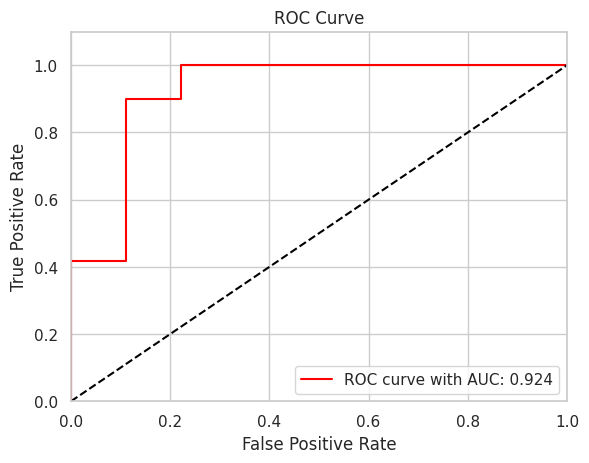

In [ ]:
from sklearn.preprocessing import LabelEncoder

predictedY = logRegModel.predict(newTrainX)


# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive = confusion_matrix(newTrainY, predictedY).ravel()
printConfusionMatrix(LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive)
print('------------------------------------------------------------------')


# Accuracy on training data
LRTrainAccuracy = logRegModel.score(newTrainX, newTrainY)
LRTrainAccuracy = round(LRTrainAccuracy, 3)
print('ACCURACY FOR TRAINING DATA:')
print(LRTrainAccuracy)
print('------------------------------------------------------------------')


# AUC value on training data
predictedYProb = logRegModel.predict_proba(newTrainX)[::,1]
le = LabelEncoder()
newTrainY_encoded = le.fit_transform(newTrainY)
LRfpr, LRtpr, _ = roc_curve(newTrainY_encoded,  predictedYProb)
LRTrainAUC = roc_auc_score(newTrainY_encoded, predictedYProb)
LRTrainAUC = round(LRTrainAUC, 3)
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(LRTrainAUC)
print('------------------------------------------------------------------')


# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(LRfpr, LRtpr, color='red', label='ROC curve with AUC: ' + str(LRTrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
LRTestDataDF = []
for i in range(X_test.shape[0]):
    splits = np.array_split(X_test[i], LRBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*LRBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])

        splitNum += 1

    # Add label
    activity = y_train[i]
    label = 'bending' if 'bending' in activity.lower() else 'non-bending'
    row.append(label)
    LRTestDataDF.append(row)

featuresToPlot.append('Activity')
LRTestDataDF = pd.DataFrame(LRTestDataDF, columns=featuresToPlot)
LRTestDataX = LRTestDataDF[bestSelectedFeatures]
LRTestDataY = LRTestDataDF['Activity']

# Accuracy on test data
LRTestAccuracy = logRegModel.score(LRTestDataX, LRTestDataY)
LRTestAccuracy = round(LRTestAccuracy, 3)

# Cross-validation Accuracy
LRValidationAccuracy = 0
for i in range(0, len(LRTableData)):
    if LRTableData[i][0]==LRBestL:
        LRValidationAccuracy = round(LRTableData[i][1], 3)
        break

tableData = []
row = []
row.append(LRBestL)
row.append(LRTestAccuracy)
row.append(LRValidationAccuracy)
tableData.append(row)
tableHeaders = ['Best L', 'Testing Accuracy', 'Cross-Validation Accuracy']
printDatainTable(tableHeaders, tableData)

+========+==================+===========================+
| Best L | Testing Accuracy | Cross-Validation Accuracy |
+========+==================+===========================+
|   9    |      0.211       |           0.971           |
+--------+------------------+---------------------------+


/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)
